In [1]:
# Import Packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, UpSampling2D, Activation
from keras import backend as K
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns

Using TensorFlow backend.


In [2]:
# Read the csv files
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

# Get X and y for training
X = train.drop(['label'], axis=1)
y = train['label']

# Train, Test and Validate Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=123)

# Reshape and Rescale the images
X_train = X_train.values.reshape(-1,28,28,1) / 255
X_test = X_test.values.reshape(-1,28,28,1) / 255
X_validate = X_validate.values.reshape(-1,28,28,1) / 255

In [3]:
# Build the autoencoder
model = Sequential()
model.add(Conv2D(14, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(14, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(1, kernel_size=3, padding='same', activation='relu'))

model.compile(optimizer='adam', loss="mse")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 14)        140       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 14)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 7)         889       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 7)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 7)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 7)           448       
__________

In [4]:
# Train the model
model.fit(X_train, X_train, epochs=3, batch_size=64, validation_data=(X_validate, X_validate), verbose=1)

Train on 25200 samples, validate on 8400 samples
Epoch 1/3
25200/25200 [==============================] - 7s 288us/step - loss: 0.0398 - val_loss: 0.0174
Epoch 2/3
25200/25200 [==============================] - 3s 122us/step - loss: 0.0242 - val_loss: 0.0134
Epoch 3/3
25200/25200 [==============================] - 3s 121us/step - loss: 0.0217 - val_loss: 0.0123


In [5]:
# Fitting testing dataset
restored_testing_dataset = model.predict(X_test)

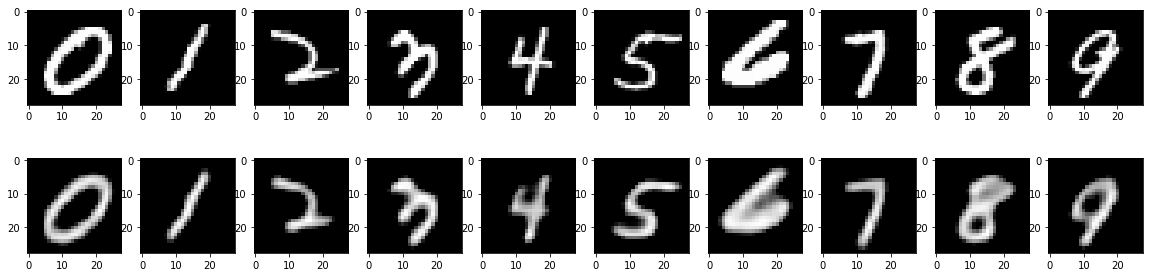

In [6]:
# Observe the reconstructed image quality
plt.figure(figsize=(20,5))
for i in range(10):
    index = y_test.tolist().index(i)
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[index].reshape((28,28)))
    plt.gray()
    plt.subplot(2, 10, i+11)
    plt.imshow(restored_testing_dataset[index].reshape((28,28)))
    plt.gray()

In [7]:
# Extract the encoder
encoder = K.function([model.layers[0].input], [model.layers[4].output])

In [8]:
# Encode the training set
encoded_images = encoder([X_test])[0].reshape(-1,7*7*7)

In [9]:
# Cluster the training set
kmeans = KMeans(n_clusters=10)
clustered_training_set = kmeans.fit_predict(encoded_images)

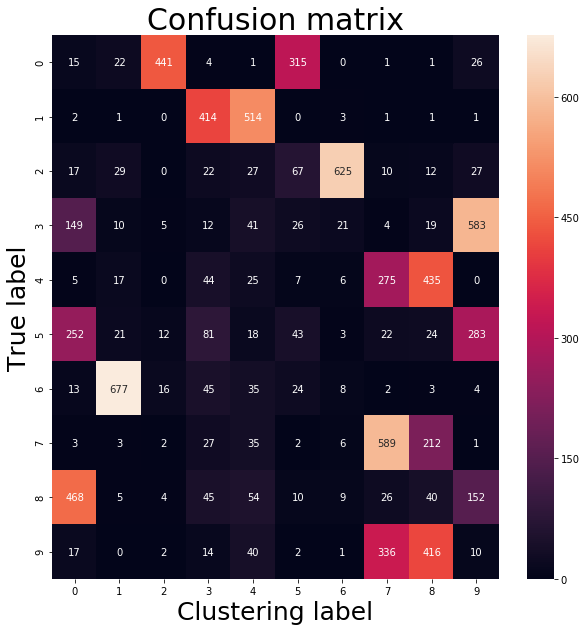

In [10]:
# Observe and compare clustering result with actual label using confusion matrix
cm = confusion_matrix(y_test, clustered_training_set)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

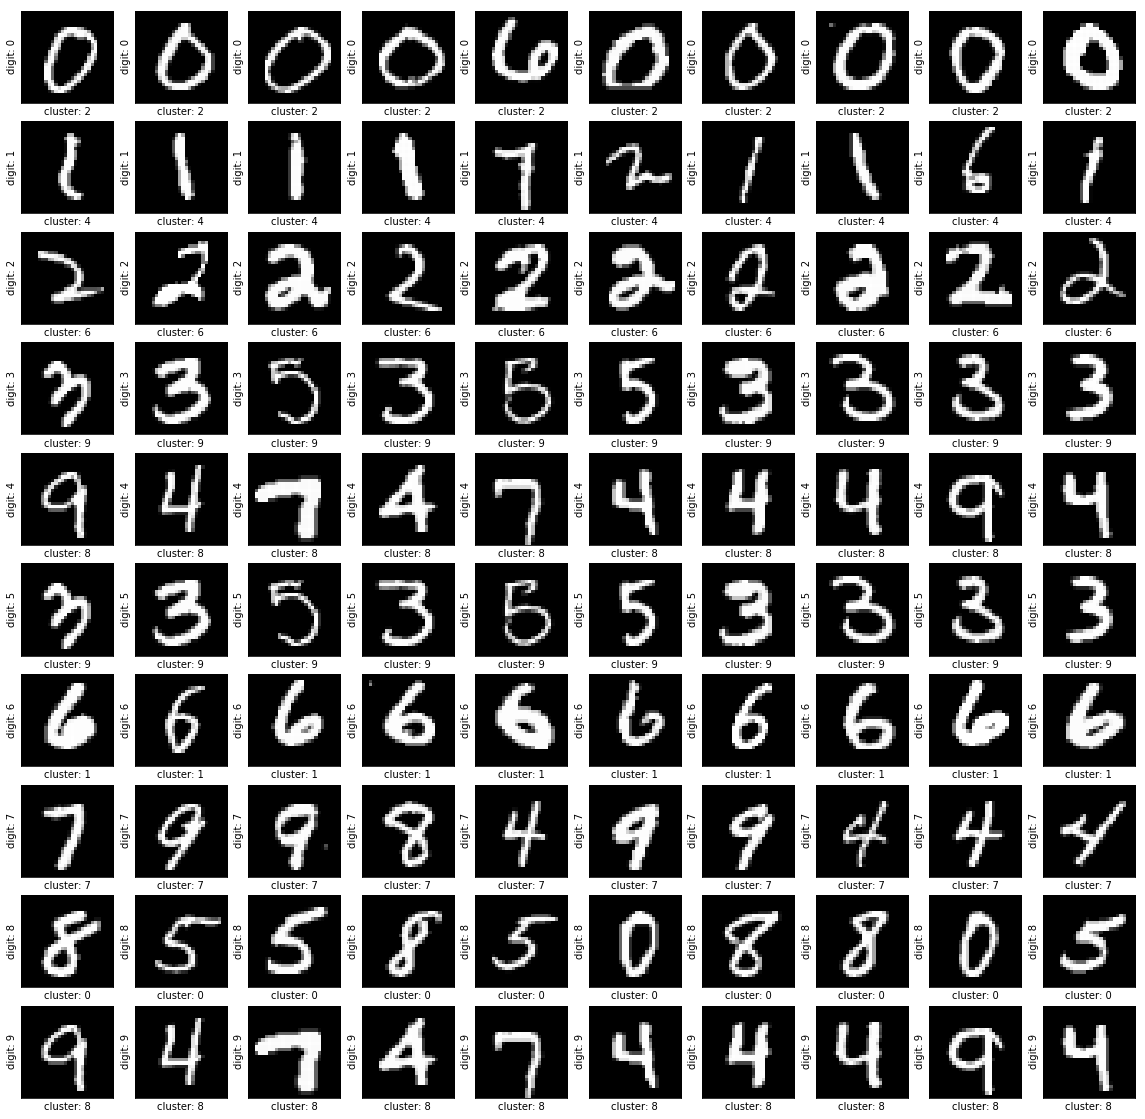

In [11]:
# Plot the actual pictures grouped by clustering
fig = plt.figure(figsize=(20,20))
for r in range(10):
    cluster = cm[r].argmax()
    for c, val in enumerate(X_test[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.ylabel('digit: '+str(r))